# SONIC model - validation of NEURON implementation for "point" simulations

## NEURON implementation

### MOD file
Each neuron-specific MOD file contains several blocks:
- **NEURON** block: defines intrinsic currents as "non-specific" (to avoid dealing with ion concentrations) and declares RANGE variables that must be accessible 
- **PARAMETER** block: sets membrane properties (conductances and reversal potentials), and sets 2 parameters: $stimon$ (controlling the stimulation state) and $A_{drive}$ (acoustic amplitude)
- **STATE** block: declares differential variables other than $v$, i.e. ion channel gating states (and possibly intermediate regulating factors)
- **ASSIGNED** block: declares variable to track during simulation: $v$, $V_{m, eff}$ and ionic currents other evolving variables
- a set of **FUNCTION_TABLE**s to perform 2D interpolation of $V_{m, eff}$ and rate constants in the (amplitude x charge)  space
- **INITIAL** block: defines initial values of states
- **BREAKPOINT** block: main computational block, solving states and computing currents
- **DERIVATIVE** block: defines differential equations for states

### Python caller
Model instantiation:
- Load mechanisms DLL file
- Create a single morphological section
- Load appropriate (amplitude x charge) interpolation tables and link them to **FUNCTION_TABLE**s in the corresponding MOD file
- Insert neuron-specific membrane mechanism.
- Set sections membrane mechanisms

Model simulation:
- Define stimulation parameters (amplitude, duration, PRF, duty cycle)
- Set probe vectors to record the evolution of $t$, $Q_m$ and $V_{m,eff}$
- Set CVODE events to turn stimulation ON and OFF at pulse onsets and offsets, respectively
- Initialize and integrate the model
- Retrieve output variables in Python

## Similarities and differences

| feature                                          | Python                                 |  Python+NEURON              |
|:------------------------------------------------:|:--------------------------------------:|:---------------------------:|
| ODE solver                                       | **LSODA (Adams method)**               | **Crank-Nicholson (cnexp)** |
| Time step                                        | **Fixed (0.05 ms)**                    | **Adaptive (atol = 0.001)** |
| Integration of US-ON periods                     | Interpolation tables                   | Interpolation tables        |
| Integration of US-OFF periods                    | **Standard equations**                 | **Interpolation tables**    |
| Computation of membrane deflection / capacitance | **Solving $P_M + P_G +P_Q - P_0 = 0$** | **None**                    |
| Computation of gas content evolution             | **Interpolation table**                | **None**                    |

## Validation 

### Imports
Let's import the necessary packages and modules.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, si_format
from PySONIC.neurons import *
from ExSONIC._0D import compare

logger.setLevel(logging.INFO)

### Parameters
Let's set some default model and stimulation parameters.

In [2]:
# Model parameters
neuron = CorticalRS()
a = 32.  # sonophore diameter

# Stimulation parameters
Fdrive = 500.  # kHz
Adrive = 50.  # kPa
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.

### Different neuron types in default conditions

---------- Creating model: SONIC0D (RS neuron, a = 32 nm, 100% cov., f = 500 kHz) ----------
loading membrane dynamics lookup tables for RS neuron
creating unique section
Setting acoustic stimulus amplitude: Adrive = 50 kPa
---------- Creating model: SONIC0D (FS neuron, a = 32 nm, 100% cov., f = 500 kHz) ----------
loading membrane dynamics lookup tables for FS neuron
creating unique section
Setting acoustic stimulus amplitude: Adrive = 50 kPa
---------- Creating model: SONIC0D (LTS neuron, a = 32 nm, 100% cov., f = 500 kHz) ----------
loading membrane dynamics lookup tables for LTS neuron
creating unique section
Setting acoustic stimulus amplitude: Adrive = 50 kPa
---------- Creating model: SONIC0D (RE neuron, a = 32 nm, 100% cov., f = 500 kHz) ----------
loading membrane dynamics lookup tables for RE neuron
creating unique section
Setting acoustic stimulus amplitude: Adrive = 50 kPa
---------- Creating model: SONIC0D (TC neuron, a = 32 nm, 100% cov., f = 500 kHz) ----------
loading m

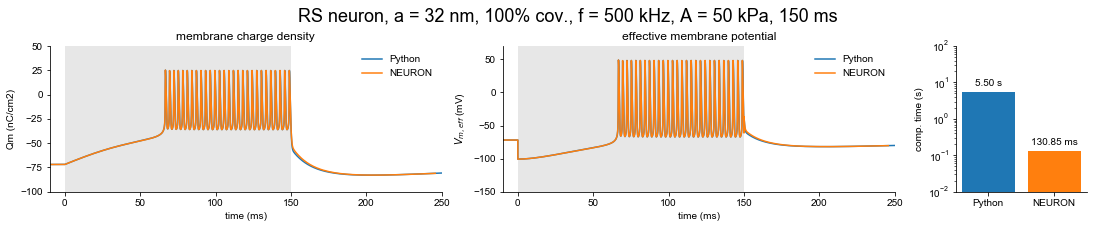

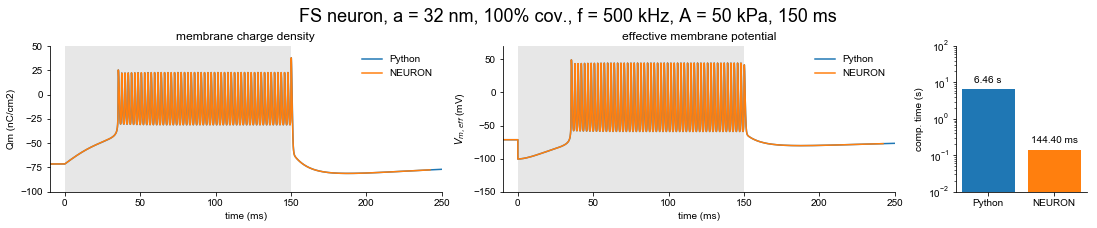

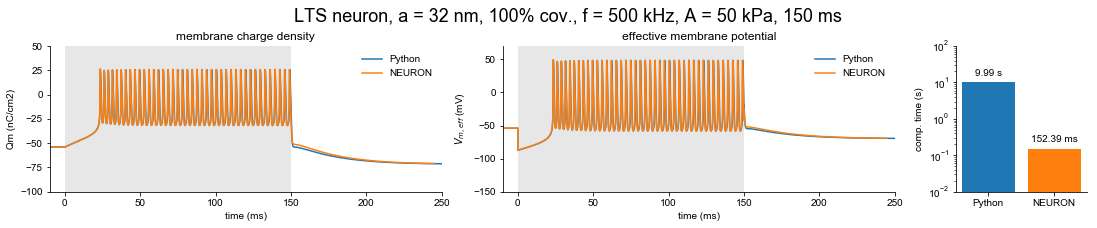

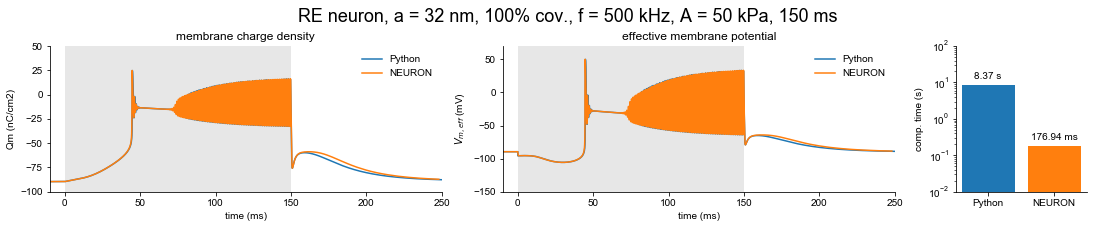

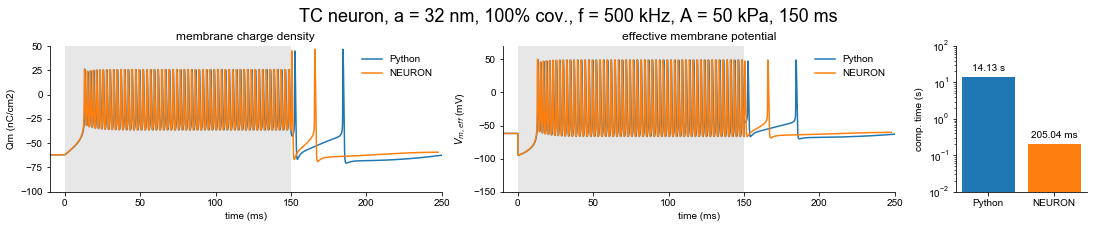

In [3]:
for neuron_str in ['RS', 'FS', 'LTS', 'RE', 'TC']:
    fig = compare(getNeuronsDict()[neuron_str](), Adrive, tstim, toffset, PRF, DC, a=a, Fdrive=Fdrive, verbose=True)

We notice, for the 5 neuron types:
- Identical build-up rates
- Identical spike trains during the stimulus
- Similar post-offset behaviors with small differences in spike timing due to sensitivity to offset resolution
- Stabilization around identical steady-state

Hence, the NEURON implementation accurately captures neuron-specific responses to a typical CW stimulus.

Moreover, it's about 2 orders of magnitude faster than the pure Python implementation.

### Influence of sonophore diameter

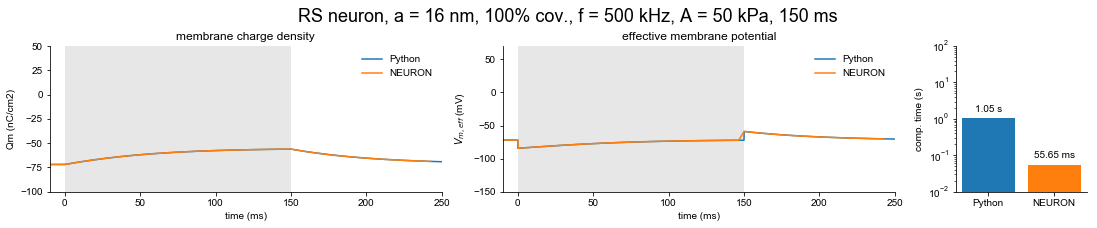

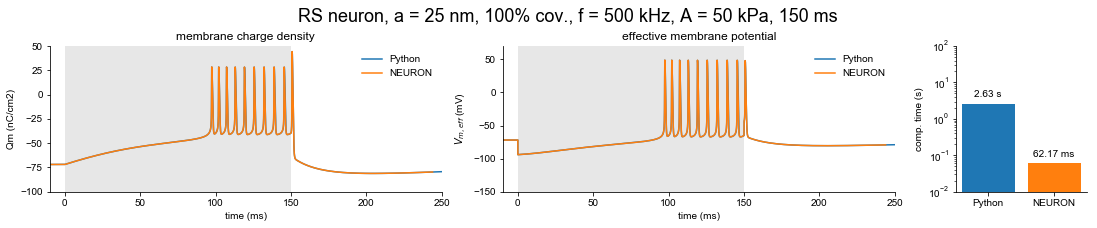

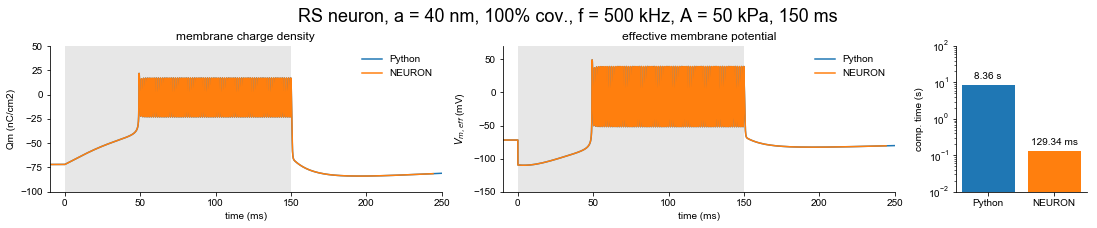

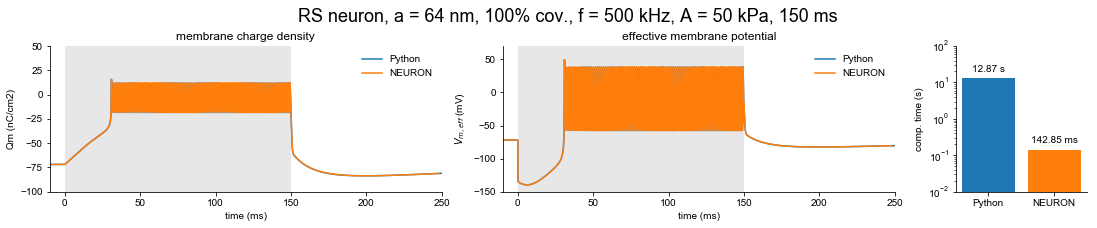

In [4]:
for a_range in np.logspace(np.log10(16.0), np.log10(64.0), 4):
    fig = compare(neuron, Adrive, tstim, toffset, PRF, DC, a=a_range, Fdrive=Fdrive)

As the sonophore diameter increases (from 16 to 64 nm), both solutions transition from a passive response to continous spike train with similar changes in spike shape (progressive reduction of spike amplitude)

### Sensitivity to stimulus frequency

 28/12/2018 16:11:19: Rounding frequency value (4000000.000000001) to interval upper bound (4000000.0)
 28/12/2018 16:11:19: Rounding frequency value (4000000.000000001) to interval upper bound (4000000.0)


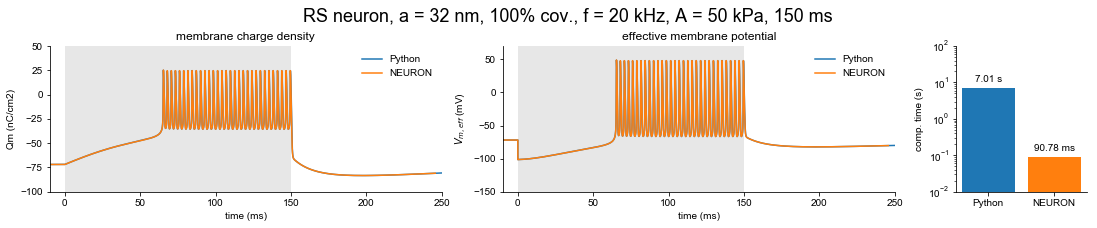

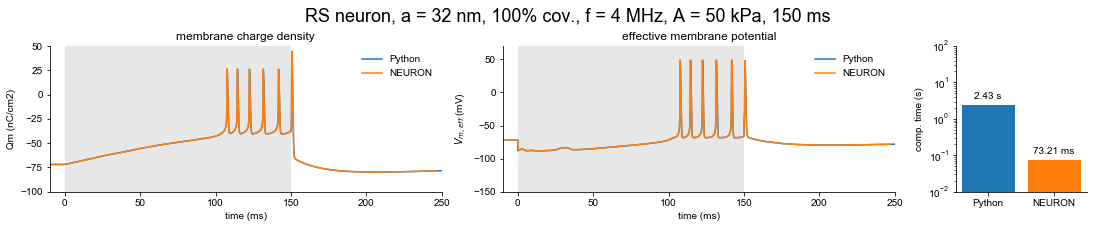

In [5]:
for Fdrive_range in np.logspace(np.log10(20), np.log10(4e3), 2):
    fig = compare(neuron, Adrive, tstim, toffset, PRF, DC, a=a, Fdrive=Fdrive_range)

We observe identical changes in spike shapes when varying US frequency within the range of lookups definitions (20 kHz - 4 MHz).

### Sensitivity to stimulus amplitude

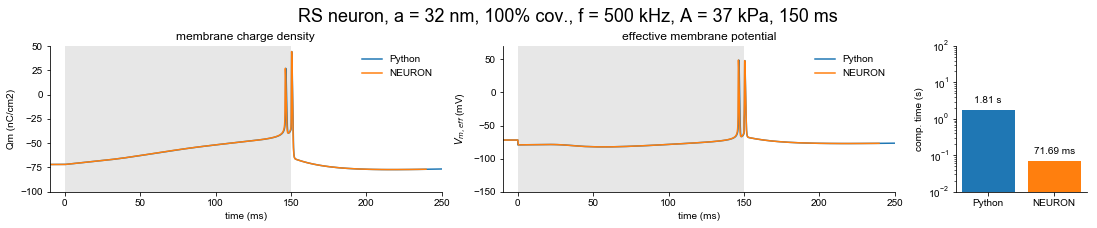

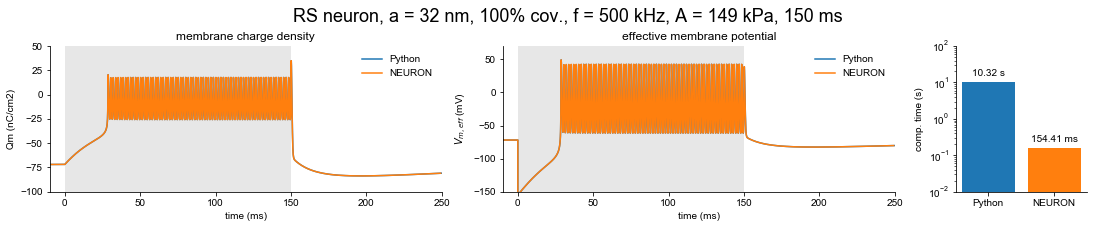

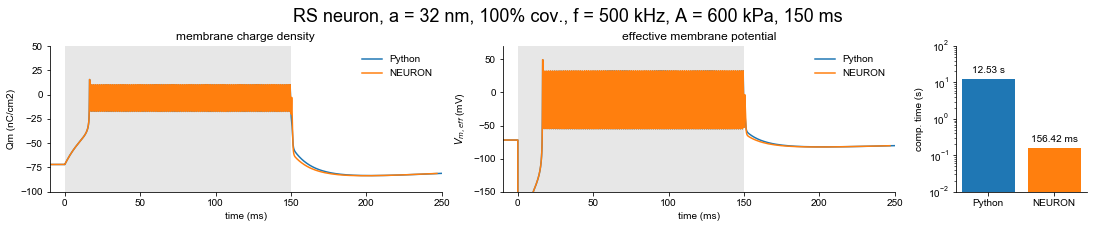

In [6]:
for Adrive_range in np.logspace(np.log10(37), np.log10(600), 3):
    fig = compare(neuron, Adrive_range, tstim, toffset, PRF, DC, a=a, Fdrive=Fdrive)

We observe identical changes in spike shapes when varying acoustic amplitude from the excitation threshold to the upper bound of lookups definitions (40 - 600 kPa).

### Sensitivity to duty cycle

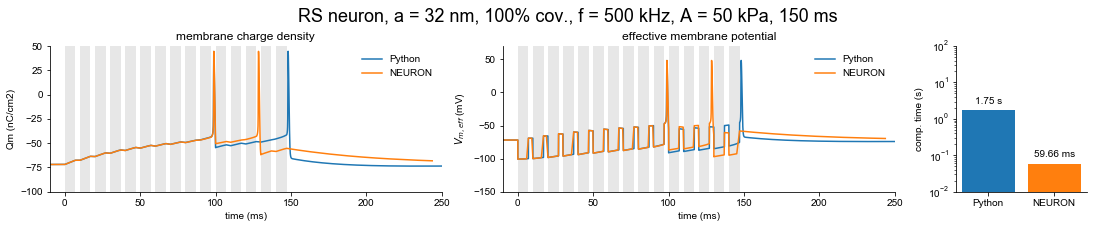

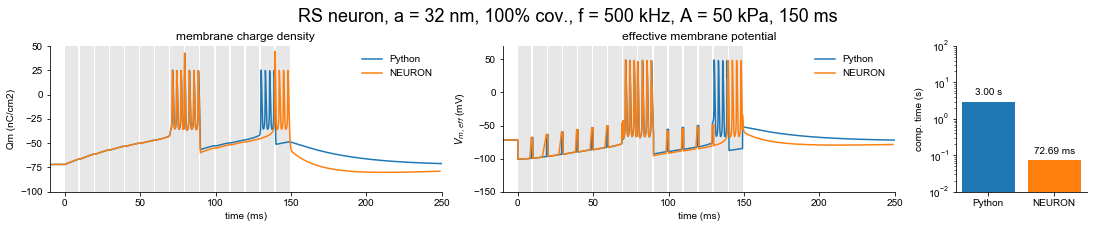

In [7]:
for DC_range in np.linspace(0.7, 0.9, 2):
    fig = compare(neuron, Adrive, tstim, toffset, PRF, DC_range, a=a, Fdrive=Fdrive)

We observe a few differences between the two solutions:

- during the build-up phase, the smooth system evolution allows NEURON's CVODE solver to use a larger time step, yielding a lower temporal resolution (seen on the $V_{m,eff}$ graphs). However, thanks to the use of CVODE events, the CVODE integrator is forced to return and re-initialize precisely at ON/OFF transitions, hence the system evolution is still accurately computed.
- as the spiking threshold is reached, NEURON's CVODE solver reduces the time step to adapt to the faster system evolution, hence spikes are properly integrated.
- a very small divergence emerges after 1 or several spike bursts, due to the tremendous sensitivity of the system to pulse-spike relative timing. This divergence is then propagated to subsequent bursts but stays reasonable and does not significantly alter the neuron's spiking metrics. 

### Increasing accuracy

We can try to increase results accuracy by setting a more stringent absolute error tolerance $a_{tol}$:

adaptive time step integration (atol = 0.001)
adaptive time step integration (atol = 1e-05)
adaptive time step integration (atol = 1e-07)


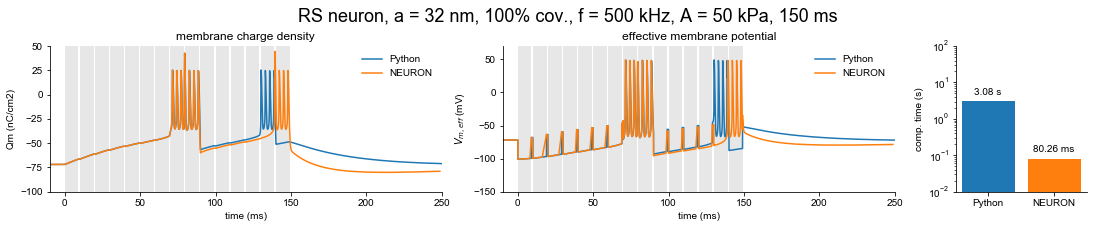

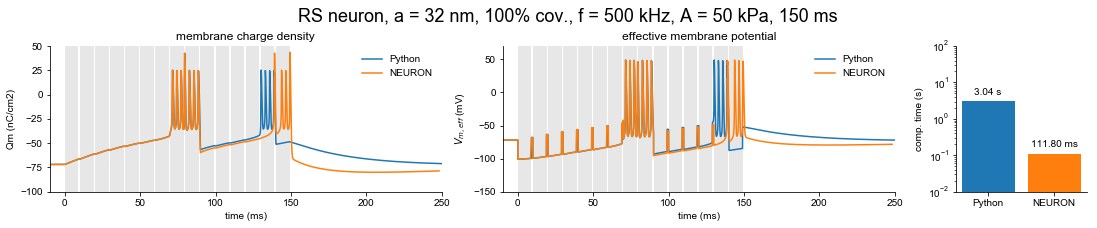

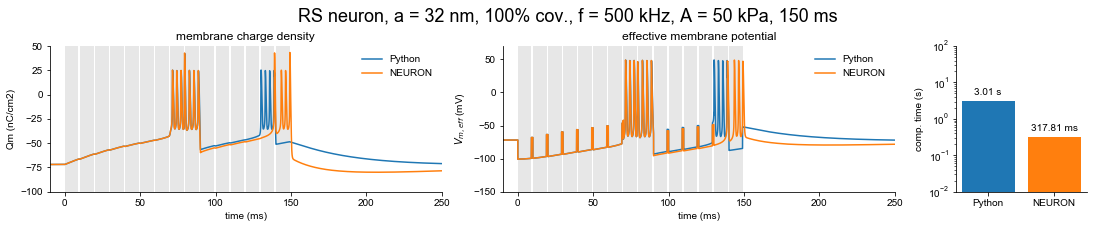

In [8]:
for atol in np.logspace(-3, -7, 3):
    fig = compare(neuron, Adrive, tstim, toffset, PRF, 0.9, a=a, Fdrive=Fdrive, atol=atol)

Divergence is not eliminated even if we reduce $a_{tol}$ by 4 orders of magnitude (down to $10^{-7}$). However, qualitative behaviors stay similar.

We can also try to increase results accuracy by forcing a small, fixed integration time step:

fixed time step integration (dt = 0.1 ms)
fixed time step integration (dt = 0.01 ms)
fixed time step integration (dt = 0.001 ms)
fixed time step integration (dt = 9.999999999999999e-05 ms)


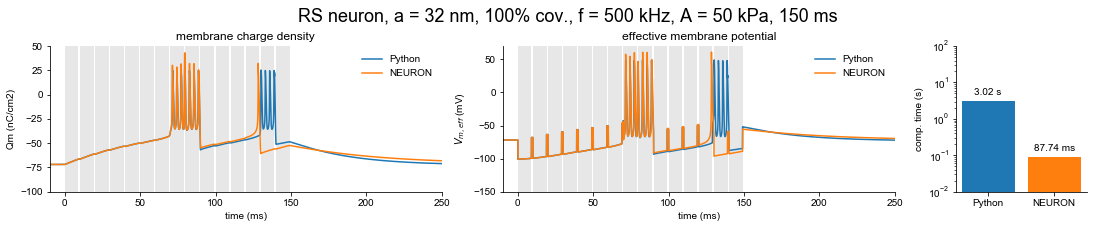

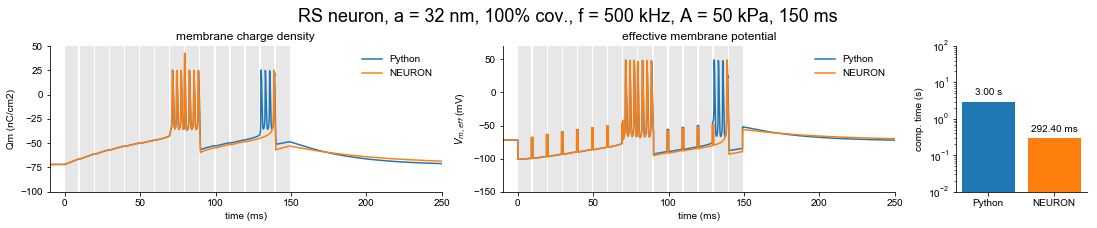

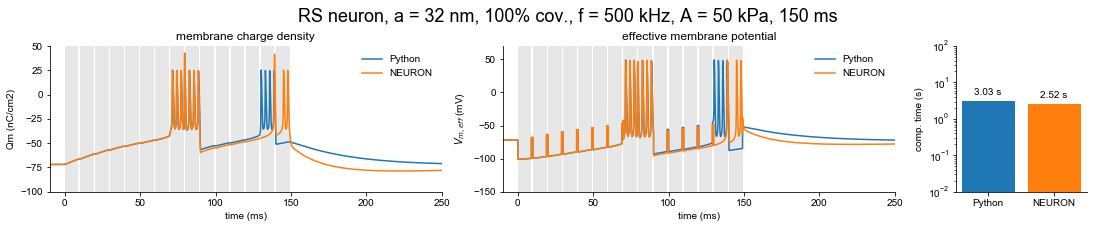

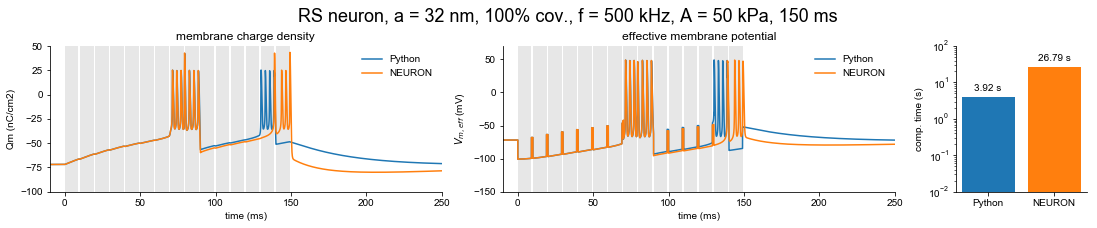

In [9]:
for dt in np.logspace(-4, -7, 4):
    fig = compare(neuron, Adrive, tstim, toffset, PRF, 0.9, a=a, Fdrive=Fdrive, dt=dt)

Divergence cannot be completely eliminated either in that case, even if we reduce $dt$ down to $0.1\ \mu s$. However, this implies a **drastic decrease in computational efficiency: simulation time is longer than the pure-Python implementation!**

Hence, the adaptive time step method seems to provide a better compromise between speed and accuracy.

## Conclusions

- **NEURON implementation can perform accurate simulations of point-neuron SONIC model**, across different cell types and parameter combinations
- Small divergences can arise for PW stimuli with many ON/OFF transitions, however these divergences can be eliminated by imposing more stringent integration conditions.
- **NEURON's adaptive integration method looks to be the most suited** for this kind of problem, as it sets a good compromise between accuracy and computational efficiency. Oppositely, the fixed time step method is either inaccurate or far less inefficient. 
- On average, **NEURON simulations with the adaptive time step method are about 2 orders of magnitude faster than pure-Python simulations**
